In [1]:
import urbanNoises
import pickle
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Feature Extraction:

We use the write_features function from urbanNoises to create temporally averaged features for each sound.

In [2]:
#urbanNoises.write_features()

## Cleaning the data

In [3]:
with open('Data/pickles/MelFeatures.pickle', 'rb') as file:
    mel=pickle.load(file)
    
with open('Data/pickles/MFCCFeatures.pickle', 'rb') as file:
    MFCC=pickle.load(file)

with open('Data/pickles/ChromaFeatures.pickle', 'rb') as file:
    chroma=pickle.load(file)

with open('Data/pickles/tonnetzFeatures.pickle', 'rb') as file:
    tonnetz=pickle.load(file)

info=pd.read_csv('Data/UrbanSound8K.csv')

features=np.concatenate((mel, MFCC, chroma, tonnetz),axis=1)

features=pd.DataFrame(features)

info = pd.concat([info, features], axis=1) 

x1, y1 = info.shape

info = info.dropna() #remove any features that were not succesfully calculated.

x2, y2 = info.shape

print('{} Rows were dropped and {} columns were dropped'.format(x1-x2,y1-y2))    



0 Rows were dropped and 0 columns were dropped


In [4]:
labels=info['class'].unique()

## Feature Assessment using a probabilistic approach:

Split into training and testing:

In [5]:
info.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,0,1,...,176,177,178,179,180,181,182,183,184,185
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,0.000027,0.000222,...,0.914163,0.788859,0.482100,0.497833,0.021190,-0.010982,-0.133131,0.094218,-0.012384,0.009034
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,0.049700,0.049527,...,0.617903,0.675770,0.693920,0.684928,-0.006520,0.004458,-0.008590,-0.001745,-0.004053,-0.000320
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,0.030849,0.028020,...,0.636775,0.646543,0.723038,0.750797,-0.013711,0.031615,-0.050797,0.020023,0.011620,0.009686
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,0.026511,0.032827,...,0.626030,0.636564,0.666254,0.679418,0.001021,0.021068,-0.009772,0.007726,0.004001,0.006359
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,0.061541,0.040469,...,0.595789,0.617314,0.691961,0.827252,-0.037152,0.074556,-0.073728,0.125956,0.042143,0.042983


In [25]:
#For this we pick fold 1 as the testing set, and the rest as the training set.

info_training=info[(info['fold']!=1) & (info['fold']!=2) & (info['fold']!=3)]
info_testing=info[(info['fold']==1) | (info['fold']==2) | (info['fold']==3)]

X_train = info_training.iloc[:, 8:].values
X_test = info_testing.iloc[:, 8:].values

y_train = info_training.iloc[:, 7].values
y_test = info_testing.iloc[:, 7].values


In [26]:
#Train the Data

In [27]:
pdfs=[]

for label in labels:
   
    Matrix=X_train[np.where(y_train==label)[0], :].T
    pdfs.append(stats.gaussian_kde(Matrix))
    print('Trained {}'.format(label))

Trained dog_bark
Trained children_playing
Trained car_horn
Trained air_conditioner
Trained street_music
Trained gun_shot
Trained siren
Trained engine_idling
Trained jackhammer
Trained drilling


In [28]:
#Test on testing set:

In [29]:
def GiveClass(Observation,pdfs,labels):
    
    vals=[]
    
    for pdf in pdfs:
        vals.append(pdf(Observation))
        
    vals=np.array(vals)
    return labels[np.argmax(vals)]

In [30]:
y_pred=[]
for i in range(len(X_test)):
    y_pred.append(GiveClass(X_test[i,:],pdfs,labels))
    

In [31]:
print('Accuracy score of {}'.format(np.mean(y_pred==y_test)))

Accuracy score of 0.31608339538346986


Normalized confusion matrix
[[0.50666667 0.28333333 0.00666667 0.01       0.07333333 0.
  0.1        0.         0.01       0.01      ]
 [0.07333333 0.73333333 0.00333333 0.05       0.08666667 0.00333333
  0.01666667 0.01       0.01333333 0.01      ]
 [0.52066116 0.04132231 0.19834711 0.         0.2231405  0.
  0.         0.         0.         0.01652893]
 [0.06666667 0.46333333 0.00333333 0.03666667 0.27       0.00333333
  0.00333333 0.01333333 0.14       0.        ]
 [0.09       0.33666667 0.         0.03666667 0.43333333 0.
  0.04666667 0.00666667 0.01       0.04      ]
 [0.37735849 0.16981132 0.         0.         0.03773585 0.29245283
  0.         0.         0.         0.12264151]
 [0.23986486 0.31081081 0.         0.01351351 0.09121622 0.
  0.33108108 0.         0.00675676 0.00675676]
 [0.13861386 0.3630363  0.         0.00660066 0.24092409 0.
  0.         0.04950495 0.20132013 0.        ]
 [0.04444444 0.18333333 0.         0.00277778 0.32222222 0.
  0.         0.         0.2     

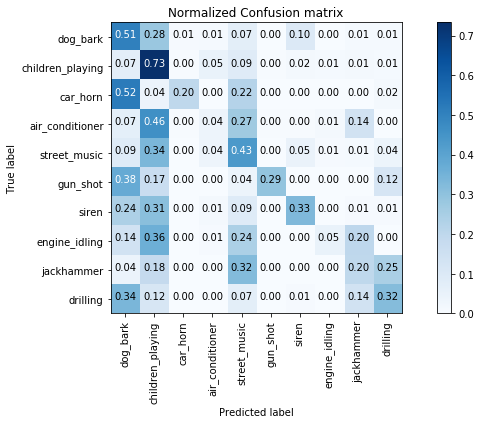

In [35]:
fig=urbanNoises.plot_confusion_matrix(y_test,y_pred,labels)
fig.tight_layout()
fig.savefig('plots/FeatureAssessment.png')
plt.show()